In [1]:
%%capture
!pip install datasets
!pip install transformers

In [2]:
# !pwd 
# !cd /home/ec2-user/SageMaker
# !rm -r model/checkpoints/*
# !rm -r cache_downloaded/*
# !ls

# !cd /home/ec2-user/SageMaker/model


In [3]:
# import csv
# with open('data/test_imbalanced.csv') as r:
#     reader = csv.reader(r)
#     next(reader)
#     i=0
#     for cols in reader:
#         print(cols)
#         i +=1
#         if i>5:
#             break

In [1]:
import pandas as pd
import numpy as np
import string
import requests
import re, json
import os
os.environ['TRANSFORMERS_CACHE'] = "./huggingface_model_cache/" 
os.environ["MODEL_DIR"] = './nlpaug_model_cache/'
os.environ['HF_DATASETS_CACHE'] = '../huggingface_dataset_cache/'

from tqdm.autonotebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from torch.utils.data import DataLoader

/tmp/ipykernel_31789/3459857794.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoConfig, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import TrainingArguments, Trainer, logging
from datasets import load_dataset, Dataset, ClassLabel, DatasetDict
from pprint import pprint

logging.set_verbosity_error()

model_ckpt = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)

## dataset

In [6]:
# balanced dataset
# dataset = load_dataset("csv", data_files={"train": "./data/train.csv", "test": "./data/test.csv"})

# imbalanced dataset
# dataset = load_dataset("csv", data_files={"train": "./data/train_imbalanced.csv", "test": "./data/test_imbalanced.csv"})
# dataset, dataset['train'].features

# update imbalanced dataset
data_files = {
    "train": "../sut-data/train.tsv", 
    "validation": "../sut-data/dev.tsv",  
    "test": "../sut-data/test.tsv",
}

path = "../sut-data/"

file_spec = {f: pd.read_csv(f"{path}{f}.tsv", sep='\t', usecols=[2, 3]) for f in ('train', 'dev', 'test')} 
        
# data should be of str format  todo
file_spec = {f: file_spec[f].applymap(str) for f in ('train', 'dev', 'test')}

# file_spec 
ds = DatasetDict()
train_ds = Dataset.from_pandas(file_spec['train'], split="train")
dev_ds = Dataset.from_pandas(file_spec['dev'], split="dev")
test_ds = Dataset.from_pandas(file_spec['test'], split="test")

ds['train'] = train_ds
ds['dev'] = dev_ds
ds['test'] = test_ds

ds

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 478
    })
    dev: Dataset({
        features: ['input', 'output'],
        num_rows: 54
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 100
    })
})

## Tokenize

In [7]:
tokenizer

T5TokenizerFast(name_or_path='google/flan-t5-large', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>

In [8]:
sut_dataset = ds

def tokenize_function(example):
    prompt = "generate templates: " + example['input']
    response = str(example["output"])

    return tokenizer(text=prompt, text_target=response, padding="max_length", truncation=True)


columns_to_remove = list(sut_dataset['train'][0].keys())
tokenized_datasets = sut_dataset.map(tokenize_function, remove_columns=columns_to_remove, batched=False)
tokenized_datasets['train'].features

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 478
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [10]:
dataset = tokenized_datasets

In [11]:
from transformers import EarlyStoppingCallback
from transformers import set_seed

seed = 42
set_seed(seed)

model = T5ForConditionalGeneration.from_pretrained(model_ckpt)



batch_size = 1
epochs = 10
logging_steps = len(dataset["train"]) // batch_size
training_args = TrainingArguments(output_dir="./trainer/checkpoints/", 
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  logging_strategy='epoch',
                                  learning_rate=1e-5,
                                  weight_decay=0.01,
                                  num_train_epochs = epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size*2,
                                  seed=0,
                                  save_total_limit = 1,
                                  load_best_model_at_end=True, # load the best model found during training at the end of training.
                                  logging_steps=logging_steps,
                                #   log_level="debug",
                                  )

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=dataset['train'],
                  eval_dataset=dataset['dev'],
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
                  )

In [12]:
trainer.train()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mlnlp. Use `wandb login --relogin` to force relogin


{'loss': 9.5404, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.3096983432769775, 'eval_runtime': 5.3976, 'eval_samples_per_second': 10.005, 'eval_steps_per_second': 5.002, 'epoch': 1.0}
{'loss': 0.4478, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.1110667809844017, 'eval_runtime': 5.3962, 'eval_samples_per_second': 10.007, 'eval_steps_per_second': 5.004, 'epoch': 2.0}
{'loss': 0.1341, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 0.08349412679672241, 'eval_runtime': 5.4011, 'eval_samples_per_second': 9.998, 'eval_steps_per_second': 4.999, 'epoch': 3.0}
{'loss': 0.1081, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 0.07359080016613007, 'eval_runtime': 5.4009, 'eval_samples_per_second': 9.998, 'eval_steps_per_second': 4.999, 'epoch': 4.0}
{'loss': 0.0965, 'learning_rate': 5e-06, 'epoch': 5.0}
{'eval_loss': 0.06930919736623764, 'eval_runtime': 5.403, 'eval_samples_per_second': 9.995, 'eval_steps_per_second': 4.997, 'epoch': 5.0}
{'loss': 0.0904

TrainOutput(global_step=4780, training_loss=1.0740991121555472, metrics={'train_runtime': 2251.6566, 'train_samples_per_second': 2.123, 'train_steps_per_second': 2.123, 'train_loss': 1.0740991121555472, 'epoch': 10.0})

## training log

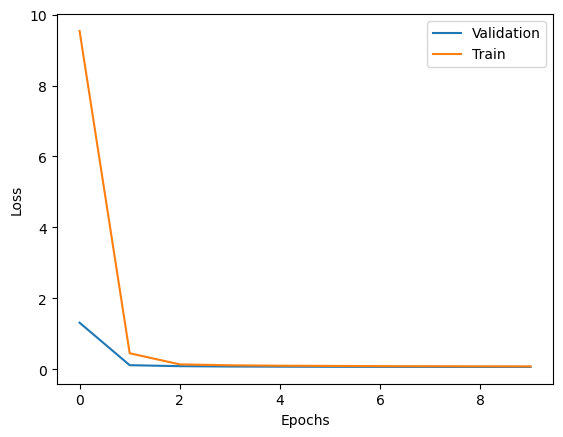

In [13]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
        .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## verification 

In [14]:
trainer.evaluate(dataset['dev'])

{'eval_loss': 0.062271423637866974, 'eval_runtime': 5.3822, 'eval_samples_per_second': 10.033, 'eval_steps_per_second': 5.017, 'epoch': 10.0}


{'eval_loss': 0.062271423637866974,
 'eval_runtime': 5.3822,
 'eval_samples_per_second': 10.033,
 'eval_steps_per_second': 5.017,
 'epoch': 10.0}

In [15]:
trainer.evaluate(dataset['test'])

{'eval_loss': 0.06357322633266449, 'eval_runtime': 9.9715, 'eval_samples_per_second': 10.029, 'eval_steps_per_second': 5.014, 'epoch': 10.0}


{'eval_loss': 0.06357322633266449,
 'eval_runtime': 9.9715,
 'eval_samples_per_second': 10.029,
 'eval_steps_per_second': 5.014,
 'epoch': 10.0}

## Save best model

In [16]:
best_model_dir = "./trainer/best_model/"
trainer.save_model(best_model_dir)

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)

In [4]:
model = T5ForConditionalGeneration.from_pretrained("./trainer/best_model/")

In [5]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

cuda


In [6]:
input_text = 'generate templates: Starting Oct 1, 2019, Avon will have a 0.5 percent sales and use tax.'
encoded = tokenizer(input_text, return_tensors='pt').to(device)
output = model.generate(**encoded,max_length=1024, )
print(tokenizer.decode(output[0], skip_special_tokens=True))

[['Avon', 'Sales and Use Tax', '0.5', '2019-10-01 00:00:00']]


In [7]:
test_data = pd.read_csv("../sut-data/test.tsv", sep="\t")
test_data

,Unnamed: 0,document_url,input,output
0,0,2020_Apr_George-740d04.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['George TBD', 'Local Sales Tax Rate', '0.019..."
1,1,2020_Apr_GigHarbor-92d49d.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Gig Harbor', 'Local Sales Tax Rate', '0.022..."
2,2,2020_Apr_GraysHarbor-bf4ccd.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
3,3,2020_Apr_GraysHarborLodging-d073f7.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Combined Sales Tax Rate'..."
4,4,2020_Apr_Yakima-561d81.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
...,...,...,...,...
95,95,local-tax-changes-10-01-2021-dd4828.pdf,"\n,Local Tax Changes\n,Effective October 1, 20...","[['Hankinson', 'City sales, use, and gross rec..."
96,96,local-tax-changes-7-1-2020-b76cfe.pdf,"Effective July 1, 2020. \nThe following local ...","[['Beulah', 'city sales, use, and alcohol gros..."
97,97,tb-01-21-7a5d19.pdf,"\n,Changes in Utah laws or Tax\n,Commission ru...","[['Orderville (Kane County)', 'Transient Room ..."
98,98,tb-02-22-a5b2d2.pdf,"\n,Changes in Utah laws or Tax\n,Commission ru...","[['Eagle Mountain (Utah County)', 'Transient R..."


In [8]:
failed_indices = []
predictions_finetuned = []
for i, row in test_data.iterrows():
    try:
        input_text = 'generate templates: ' + row.input
        encoded = tokenizer(input_text, return_tensors='pt', max_length=4096).to(device)
        pred = model.generate(**encoded,max_length=4096, )
        pred_text = tokenizer.decode(pred[0], skip_special_tokens=True)
        predictions_finetuned.append(pred_text)
        print(i)
        print(pred_text)
    except:
        print(f"{i} failed")
        failed_indices.append("[[]]")
    

0
[['Unincorp. Areas', 'Local Sales Tax Rate', '0.017', 'nan', '2020-04-01 00:00:00'], ['Unincorp. Areas', 'State Sales Tax Rate', '0.065', 'nan', '2020-04-01 00:00:00'], ['Unincorp. Areas', 'Total Sales Tax Rate', '0.082', 'nan', '2020-04-01 00:00:00'], ['Coulee City', 'Local Sales Tax Rate', '0.017', 'nan', '2020-04-01 00:00:00'], ['Coulee City', 'State Sales Tax Rate', '0.065', 'nan', '2020-04-01 00:00:00'], ['Coulee City', 'Total Sales Tax Rate', '0.082', 'nan', '2020-04-01 00:00:00'], ['Electric City', 'Local Sales Tax Rate', '0.017', 'nan', '2020-04-01 00:00:00'], ['Electric City', 'State Sales Tax Rate', '0.065', 'nan', '2020-04-01 00:00:00'], ['Electric City', 'Total Sales Tax Rate', '0.082', 'nan', '2020-04-01 00:00:00'], ['Ephrata', 'Local Sales Tax Rate', '0.019', 'nan', '2020-04-01 00:00:00'], ['Ephrata', 'State Sales Tax Rate', '0.065', 'nan', '2020-04-01 00:00:00'], ['Ephrata', 'Total Sales Tax Rate', '0.084', 'nan', '2020-04-01 00:00:00'], ['George TBD', 'Local Sales Tax

In [9]:
len(predictions_finetuned)

100

In [13]:
test_data['predictions'] = predictions_finetuned


In [16]:
test_data

,Unnamed: 0,document_url,input,output,predictions
0,0,2020_Apr_George-740d04.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['George TBD', 'Local Sales Tax Rate', '0.019...","[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
1,1,2020_Apr_GigHarbor-92d49d.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Gig Harbor', 'Local Sales Tax Rate', '0.022...","[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
2,2,2020_Apr_GraysHarbor-bf4ccd.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Local Sales Tax Rate', '...","[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
3,3,2020_Apr_GraysHarborLodging-d073f7.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Combined Sales Tax Rate'...","[['Unincorp. Areas', 'Lodging Sales Tax Rate',..."
4,4,2020_Apr_Yakima-561d81.pdf,WASHINGTON STATE DEPARTMENT OF REVENUE. LOCAL ...,"[['Unincorp. Areas', 'Local Sales Tax Rate', '...","[['Unincorp. Areas', 'Local Sales Tax Rate', '..."
...,...,...,...,...,...
95,95,local-tax-changes-10-01-2021-dd4828.pdf,"\n,Local Tax Changes\n,Effective October 1, 20...","[['Hankinson', 'City sales, use, and gross rec...","[['Hankinson', 'city sales, use, and gross rec..."
96,96,local-tax-changes-7-1-2020-b76cfe.pdf,"Effective July 1, 2020. \nThe following local ...","[['Beulah', 'city sales, use, and alcohol gros...","[['Beulah', 'city sales, use, and gross receip..."
97,97,tb-01-21-7a5d19.pdf,"\n,Changes in Utah laws or Tax\n,Commission ru...","[['Orderville (Kane County)', 'Transient Room ...","[['Orderville (Kane County)', 'April 1, 2021',..."
98,98,tb-02-22-a5b2d2.pdf,"\n,Changes in Utah laws or Tax\n,Commission ru...","[['Eagle Mountain (Utah County)', 'Transient R...","[['Rich County', 'Transient Room Tax Rate', '4..."


In [17]:
test_data.to_csv("rui-finetuned-flant5.tsv", sep='\t', index=False)

In [25]:
# from transformers import pipeline
# pipe = pipeline(task="text2text-generation", model=model, tokenizer=tokenizer, max_length=1024, device_map="auto")

# result = pipe("generate templates: Starting Oct 1, 2019, Avon will have a 0.5 percent sales and use tax.")
# print(result[0]['generated_text'])

In [ ]:
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# # model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# inputs = tokenizer("Seattle logging tax is 5%, and it starts on Jan 01, 2023, and it expires on May 08, 2025", return_tensors="pt").to(device)
# outputs = model.generate(**inputs)
# print(tokenizer.batch_decode(outputs, skip_special_tokens=True))